<a href="https://colab.research.google.com/github/HikaruEgashira/tutorial-pytorch/blob/master/12_data_loading_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline


データの読み込み
====================================
**Author**: `Sasank Chilamkurthy <https://chsasank.github.io>`_

以下のパッケージをインストールします。

-  ``scikit-image``: 画像の入出力と変形
-  ``pandas``: CSVの成形




In [0]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# 警告を無視する
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # 対話モード

顔の表情を処理してあるデータセットを扱っていきます。

.. figure:: /_static/img/landmarked_face2.png
   :width: 400

それぞれに68もの異なる部位がポイントされています

<div class="alert alert-info"><h4>注意</h4>
  <p>以下のurlからデータセットをダウンロードしてきます `here <https://download.pytorch.org/tutorial/faces.zip>`_
    'faces/'以下にそのデータを配置します。
    
    This dataset was actually
    generated by applying excellent `dlib's pose
    estimation <http://blog.dlib.net/2014/08/real-time-face-pose-estimation.html>`__
    on a few images from imagenet tagged as 'face'.
</p></div>

以下のように注釈付きでcsvファイルが付属してきます。
  
::

    image_name,part_0_x,part_0_y,part_1_x,part_1_y,part_2_x, ... ,part_67_x,part_67_y
    0805personali01.jpg,27,83,27,98, ... 84,134
    1084239450_e76e00b7e7.jpg,70,236,71,257, ... ,128,312

  CSVファイルを読み込み（N、２）配列で取得しましょう
  （Nは特徴量）



In [0]:
!wget https://download.pytorch.org/tutorial/faces.zip

--2019-05-03 06:02:40--  https://download.pytorch.org/tutorial/faces.zip
Resolving download.pytorch.org (download.pytorch.org)... 99.84.194.17, 99.84.194.32, 99.84.194.47, ...
Connecting to download.pytorch.org (download.pytorch.org)|99.84.194.17|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5780252 (5.5M) [application/zip]
Saving to: ‘faces.zip’

faces.zip           100%[===================>]   5.51M  1.35MB/s    in 4.4s    

2019-05-03 06:02:45 (1.26 MB/s) - ‘faces.zip’ saved [5780252/5780252]



In [0]:
!unzip faces.zip

Archive:  faces.zip
replace faces/0805personali01.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: faces/0805personali01.jpg  
replace faces/1084239450_e76e00b7e7.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: faces/1084239450_e76e00b7e7.jpg  
  inflating: faces/10comm-decarlo.jpg  
  inflating: faces/110276240_bec305da91.jpg  
  inflating: faces/1198_0_861.jpg    
  inflating: faces/137341995_e7c48e9a75.jpg  
  inflating: faces/1383023626_8a49e4879a.jpg  
  inflating: faces/144044282_87cf3ff76e.jpg  
  inflating: faces/152601997_ec6429a43c.jpg  
  inflating: faces/1549040388_b99e9fa295.jpg  
  inflating: faces/1878519279_f905d4f34e.jpg  
  inflating: faces/2046713398_91aaa6fe1c.jpg  
  inflating: faces/2173711035_dbd53b4f9f.jpg  
  inflating: faces/2210514040_6b03ff2629.jpg  
  inflating: faces/2322901504_08122b01ba.jpg  
  inflating: faces/2327253037_66a61ea6fe.jpg  
  inflating: faces/2328398005_d328a70b4c.jpg  
  inflating: faces/2370961440_6bc8ce346c.jpg  
  in

In [0]:
!rm faces.zip

In [0]:
landmarks_frame = pd.read_csv('faces/face_landmarks.csv')

# 65: 特徴量
n = 65
# [名前, ...特徴]
img_name = landmarks_frame.iloc[n, 0]
landmarks = landmarks_frame.iloc[n, 1:].as_matrix()
landmarks = landmarks.astype('float').reshape(-1, 2)

print('Image name: {}'.format(img_name))
print('Landmarks shape: {}'.format(landmarks.shape))
print('First 4 Landmarks: {}'.format(landmarks[:4]))

Image name: person-7.jpg
Landmarks shape: (68, 2)
First 4 Landmarks: [[32. 65.]
 [33. 76.]
 [34. 86.]
 [34. 97.]]


画像と特徴の表示と例の表示




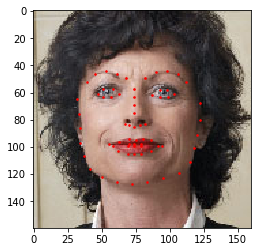

In [0]:
def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    # 画像の表示
    plt.imshow(image)
    # 点を表示
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)  # 表が更新されるまで少々停止

plt.figure()
show_landmarks(io.imread(os.path.join('faces/', img_name)),
               landmarks)
plt.show()

データセットクラス
-------------

``torch.utils.data.Dataset`` はデータセットを表しています

``Dataset``を継承しており、以下のメゾッドをオーバーライドしています

-  ``__len__`` つまり ``len(dataset)`` はデータセットを返す
-  ``__getitem__`` は番号をつける ``dataset[i]`` は$i$ 番目を表しています

``__init__`` : csvファイルを読み取り
``__getitem__``: 画像の読み取り

これはすべての画像をメモリに蓄えるのがよくないからです。

辞書は

```
{
  'image': image,
  'landmarks': landmarks
}
```
となる

``transform`` というオプションの引数は次のセクションで有用です。




In [0]:
class FaceLandmarksDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        # 画像情報の取得
        img_name = os.path.join(self.root_dir,
                                self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:].as_matrix()
        landmarks = landmarks.astype('float').reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample

はじめの４つを出力

0 (324, 215, 3) (68, 2)


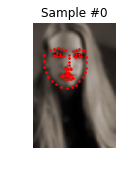

1 (500, 333, 3) (68, 2)


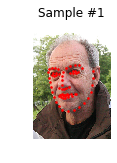

2 (250, 258, 3) (68, 2)


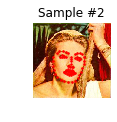

3 (434, 290, 3) (68, 2)


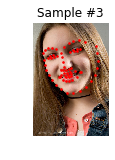

In [0]:
face_dataset = FaceLandmarksDataset(csv_file='faces/face_landmarks.csv',
                                    root_dir='faces/')

fig = plt.figure()

for i in range(len(face_dataset)):
    sample = face_dataset[i]

    print(i, sample['image'].shape, sample['landmarks'].shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    # 画像の表示
    show_landmarks(**sample)

    # 4枚目で終了
    if i == 3:
        plt.show()
        break

変換 Transforms
----------

画像の大きさが異なる場合に均一にする必要がある
そのために以下のメゾッドを追加する

-  ``Rescale``: スケールの変更
-  ``RandomCrop``: データの引数としてランダムに画像をトリミング
-  ``ToTensor``: numpy画像をtensor型に

単純な関数ではなく呼び出し可能なクラスとしてそれらを書くので、パラメータは呼び出されるたびに渡される必要はありません。
なので、__ call__メソッドと、オプションで__init__メソッドを実装するだけでメゾッドが呼び出されるようにします。それから、このような変換を使うこともできます

::

    tsfm = Transform(params)
    transformed_sample = tsfm(sample)

以下の実装を見て、どのようにこれらの変換で画像と特徴の両方に適用されているのかを見ていきましょう.




In [0]:
class Rescale(object):
    """サンプル内の画像をRescaleして与えられたサイズにします
    
    args:
        output_size (タプル or 整数): 望む出力サイズ. タプルならその値で出力され、
        整数なら画像の短辺にそろえて比率を変えないように出力されます。
    """

    def __init__(self, output_size):
        # 型チェック
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    # 呼ばれたときにサイズの変更を実行する
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        # 画像なので、hとwは入れ替わる
        # x軸とy軸はそれぞれ軸1と0を表す。
        landmarks = landmarks * [new_w / w, new_h / h]

        return {'image': img, 'landmarks': landmarks}


class RandomCrop(object):
    """サンプル内の画像をトリミングします。

    Args:
        output_size (tuple or int): 出力サイズを指定。
        整数値なら正方形にクロップされる
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        landmarks = landmarks - [left, top]

        return {'image': image, 'landmarks': landmarks}


class ToTensor(object):
    """サンプルのnumpy配列をTensor型に変換します"""

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        # 色の軸の交換
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks)}

変換の構成 Compose transforms
==


画像の短辺を256に拡大縮小し、それからそれから224のサイズの正方形にトリミングします。 torchvision.transforms.Composeで可能です。




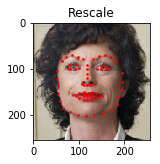

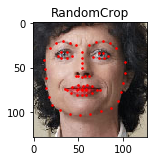

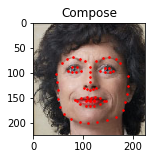

In [0]:
scale = Rescale(256)
crop = RandomCrop(128)
composed = transforms.Compose([Rescale(256),
                               RandomCrop(224)])

# サンプルに上で定義した変換を適用する
fig = plt.figure()
sample = face_dataset[65]
# scale => crop => composed
for i, tsfrm in enumerate([scale, crop, composed]):
    transformed_sample = tsfrm(sample)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    show_landmarks(**transformed_sample)

plt.show()

データセットの繰り返し数 Iterating through the dataset
-----------------------------

毎回データセットは以下のようにサンプリングされます

-  画像は空中のファイルから読み込まれますAn image is read from the file on the fly
-  読み取り用画像を変形させます Transforms are applied on the read image
-  変換はランダムであるため、データはサンプリング時に増強されます。Since one of the transforms is random, data is augmentated on
   sampling

作成したデータセットをfor iで処理できます。




In [0]:
transformed_dataset = FaceLandmarksDataset(csv_file='faces/face_landmarks.csv',
                                           root_dir='faces/',
                                           transform=transforms.Compose([
                                               Rescale(256),
                                               RandomCrop(224),
                                               ToTensor()
                                           ]))
# 先頭4つを表示
for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]

    print(i, sample['image'].size(), sample['landmarks'].size())

    if i == 3:
        break

0 torch.Size([3, 224, 224]) torch.Size([68, 2])
1 torch.Size([3, 224, 224]) torch.Size([68, 2])
2 torch.Size([3, 224, 224]) torch.Size([68, 2])
3 torch.Size([3, 224, 224]) torch.Size([68, 2])


-  データのバッチサイズ
-  データのシャッフル
-  並列処理でのデータの読み込み

を実装します

torch.utils.data.DataLoaderは、これらすべての機能を提供するイテレータです。以下で使用されるパラメータは明確であるべきです。関心のある1つのパラメーターはcollate_fnです。 collate_fnを使用して、サンプルをどの程度正確にバッチ処理する必要があるかを指定できます。ただし、デフォルトの照合順序はほとんどのユースケースで正常に機能するはずです。




0 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
1 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
2 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
3 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])


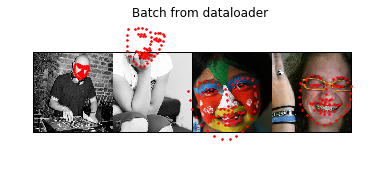

In [0]:
# 引数はバッチサイズ、シャッフルするか、読み込みに使うコア数
dataloader = DataLoader(transformed_dataset, batch_size=4,
                        shuffle=True, num_workers=4)


# バッチを示すために役立つ関数
def show_landmarks_batch(sample_batched):
    """
    バッチごとのサンプルのランドマークと画像を表示
    Show image with landmarks for a batch of samples.
    """
    images_batch, landmarks_batch = \
            sample_batched['image'], sample_batched['landmarks']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    for i in range(batch_size):
        plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size,
                    landmarks_batch[i, :, 1].numpy(),
                    s=10, marker='.', c='r')

        plt.title('Batch from dataloader')

for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['landmarks'].size())

    # observe 4th batch and stop.
    if i_batch == 3:
        plt.figure()
        show_landmarks_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

あとがき: torchvision
----------------------

どのように読み取るのかについて説明してきた。
``torchvision``パッケージはいくつかの共通のデータセットと変換を提供しているので
独自のクラスを書く必要はないかもしれません。

例として、``ImageFolder``を説明します。
以下のような画像フォルダの構成を想定すると、

    root/ants/xxx.png
    root/ants/xxy.jpeg
    root/ants/xxz.png
    .
    .
    .
    root/bees/123.jpg
    root/bees/nsdf3.png
    root/bees/asd932_.png


 'ants', 'bees' などがクラス名になります。それらは``PIL.Image``操作で``RandomHorizontalFlip``, ``Scale``を使うことが可能です。
 以下のように書き込むこともできます。

::

  import torch
  from torchvision import transforms, datasets

  data_transform = transforms.Compose([
          transforms.RandomSizedCrop(224),
          transforms.RandomHorizontalFlip(),
          transforms.ToTensor(),
          transforms.Normalize(mean=[0.485, 0.456, 0.406],
                               std=[0.229, 0.224, 0.225])
      ])
  hymenoptera_dataset = datasets.ImageFolder(root='hymenoptera_data/train',
                                             transform=data_transform)
  dataset_loader = torch.utils.data.DataLoader(hymenoptera_dataset,
                                               batch_size=4, shuffle=True,
                                               num_workers=4)

学習用コードは以下を見てください
:doc:`transfer_learning_tutorial`.

